In [1]:
import numpy as np

# Components
## Network
- Network class is construct network

In [2]:
class Network:
    def __init__(self, cost=None, max_iteration=1000):
        self.max_iteration = max_iteration
        self.layers = []
        self.cost_history = []
        self.cost = cost
        
    def __repr__(self):
        base = "Network(cost={}, max_iteration={})".format(self.cost.__name__, self.max_iteration)
        for layer in self.layers:
            base = base + ".add_layer(\n    {}\n)".format(layer)
        return base
    
    def add_layer(self, layer):
        if len(self.layers) == 0:
            # added bias
            layer.input_size += 1
            layer.weights = np.random.normal(size=(layer.hidden_size, layer.input_size))
        self.layers.append(layer)
        return self
    
    def fit(self, x, y):
        self.cost_history = []
        
        x = np.insert(x[:, np.newaxis] if x.ndim ==1 else x, 0, 1, axis=1)
        y = y[:, np.newaxis] if y.ndim == 1 else y

        for i in range(self.max_iteration):
            N = x.shape[0]
            # forward
            a = x
            a_history = []
            for layer in self.layers:
                a_history.append(a)
                z = layer.forward(a)
                if layer.activation:
                    a = layer.activation.forward(z)
                else:
                    a = z
            
            cost = self.cost.error(a, y)
            self.cost_history.append(cost)
            
            # back propagation
            delta = self.cost.delta(a, y)
            for layer, a in zip(self.layers[::-1], a_history[::-1]):
                delta = layer.backward(a, delta)
                
    def predict(self, x):
        a = np.insert(x[:, np.newaxis] if x.ndim ==1 else x, 0, 1, axis=1)
        for layer in self.layers:
            z = layer.forward(a)
            a = layer.activation.forward(z) if layer.activation else z
        return a

## Layer
### DenseLayer

In [3]:
class DenseLayer:
    def __init__(self, input_size=1, hidden_size=1, learning_rate=0.0001, activation=None):
        self.learning_rate = learning_rate
        self.given_input_size = input_size
        self.input_size = input_size
        self.hidden_size = hidden_size
        np.random.seed(4)
        self.weights = np.random.normal(size=(hidden_size, input_size))
        self.activation = activation
    
    def forward(self, x):
        return np.dot(x, self.weights.T)
    
    def backward(self, a, delta):
        d = self.activation.backward(delta) if self.activation else delta
        ret = np.dot(d, self.weights)
        self.update(a, d)
        return ret
    
    def update(self, a, delta):
        self.weights = self.weights - self.learning_rate * np.dot(delta.T, a)
        
    def __repr__(self):
        return "DenseLayer(input_size={}, hidden_size={}, learning_rate={}, activation={})".format(self.given_input_size, self.hidden_size, self.learning_rate, self.activation.__name__ if self.activation is not None else None)

## Activation Function
### Relu

In [4]:
class Relu:
    def forward(x):
        x_ret = x.copy()
        x_ret[x <= 0] = 0
        return x_ret

    def backward(x):
        x_ret = x.copy()
        x_ret[x > 0] = 1
        x_ret[x <= 0] = 0
        return x

## Cost function
### MAE

In [5]:
class MeanSquareError:
    def error(y, t):
        return np.sum((y-t)**2) / t.shape[0]
    
    def delta(y, t):
        return y-t

# Sample


## Generating Data

In [6]:
def original_function(x):
    np.random.seed(4)
    return 0.4 * (x-5)**2 + np.random.normal(size=(x.shape[0],))

x = np.arange(0, 10, 0.1)
y = original_function(x)

## Construct Network & fitting

In [7]:
net = Network(cost=MeanSquareError, max_iteration=100000)
net.add_layer(
    DenseLayer(input_size=1, hidden_size=15, learning_rate=0.00001, activation=Relu)
).add_layer(
    DenseLayer(input_size=15, hidden_size=10, learning_rate=0.00001, activation=Relu)
).add_layer(
    DenseLayer(input_size=10, learning_rate=0.00001)
)

net.fit(x, y)

## Draw Graph

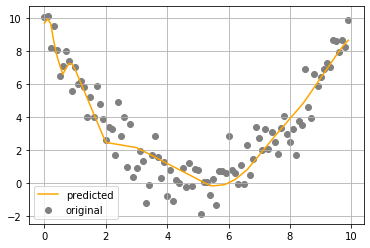

In [9]:
import matplotlib.pyplot as plt
plt.scatter(x, y, color="gray", label="original")
plt.plot(x, net.predict(x), color="orange", label="predicted")
plt.legend()
plt.grid()